In [19]:
import polars as pl
import numpy as np
from scipy.stats import median_abs_deviation

# Read the data
df = pl.read_parquet("")

# Define the Hampel filter function
def hampel_filter(data, window_size=21, threshold=3):
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd integer.")

    # 1. Create sliding windows
    windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=window_size)

    # 2. Calculate medians and MADs for all windows
    medians = np.median(windows, axis=1)
    mads = np.array([median_abs_deviation(w, scale=1.0) for w in windows])

    # 3. Find outliers and replace them
    half_window = int(window_size / 2)
    center_points = data[half_window:-half_window]
    outliers = np.abs(center_points - medians) > (threshold * mads)

    # 4. Create output array
    result = data.copy()
    result[half_window:-half_window] = np.where(outliers, medians, center_points)

    return result

# Extract the values and apply the filter
values_array = df["value"].to_numpy()
filtered_values = hampel_filter(values_array)

# Create the output DataFrame
output_df = pl.DataFrame({
    "stid": df["stid"],
    "date_time": df["date_time"],
    "snow_depth": filtered_values
})

# Save to parquet
output_df.write_parquet("")

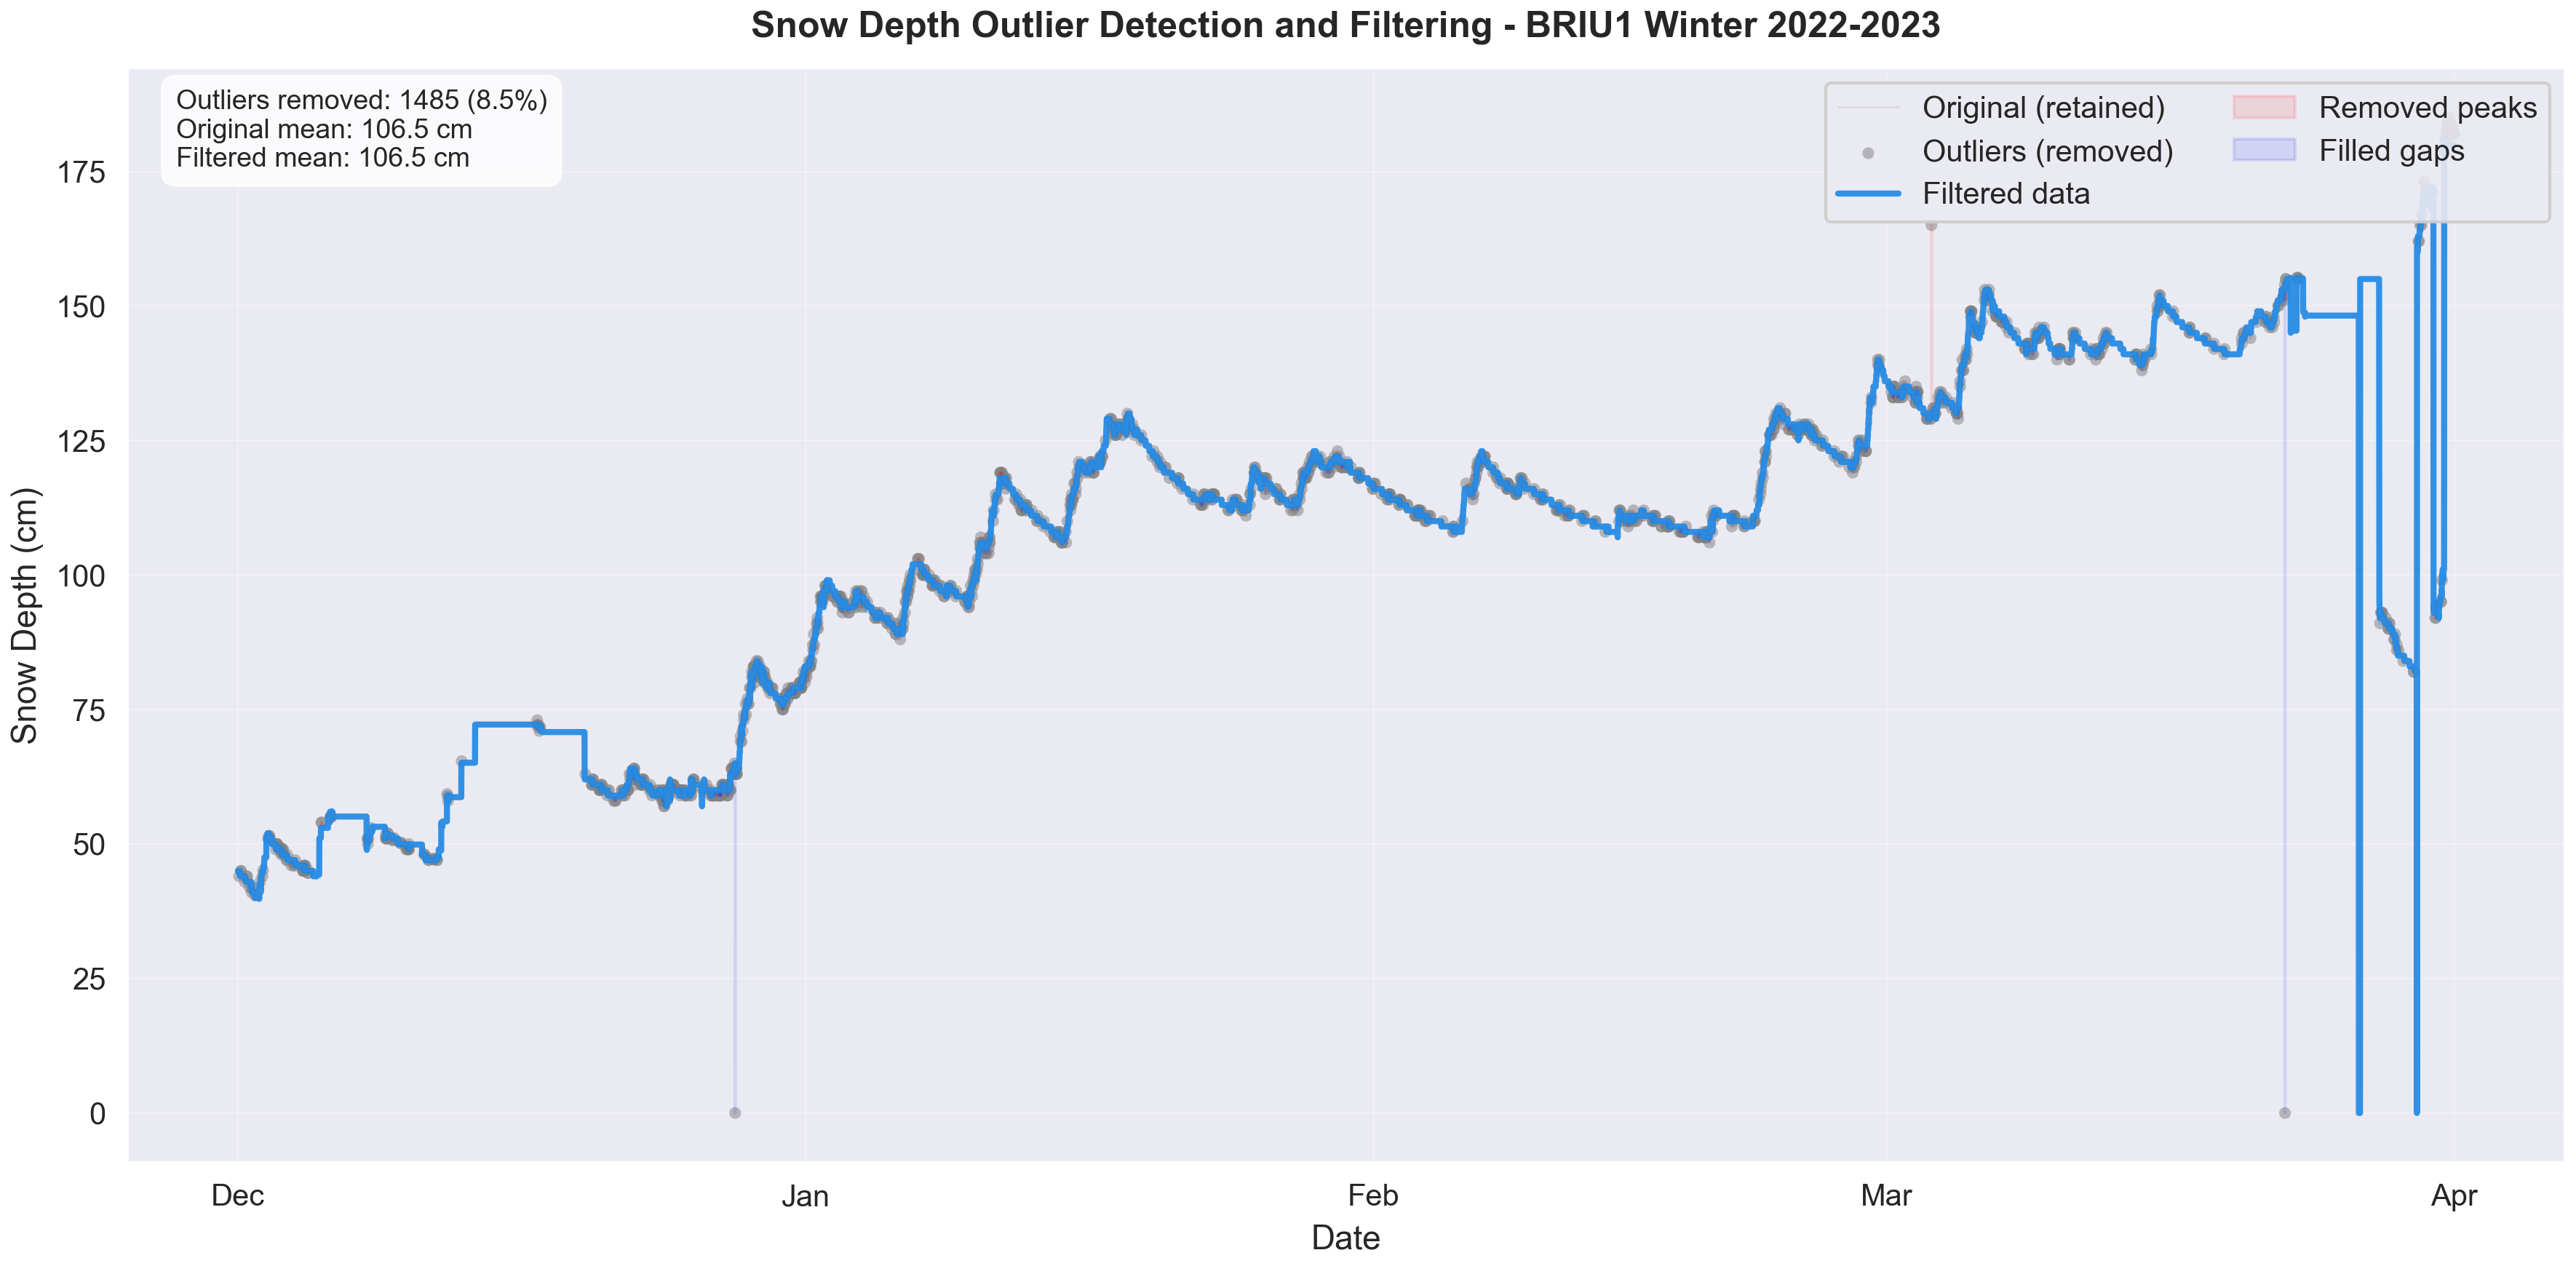

Snow depth filtering and visualization completed successfully!


In [16]:
import polars as pl
import numpy as np
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series

# Read the data from parquet file
data_frame = pl.read_parquet("")


# Define the Hampel filter function with explicit steps
def hampel_filter_function(input_data, window_size=21, threshold=3):
    # Check that window size is odd
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd integer.")

    # Step 1: Create sliding windows from the input data
    sliding_windows = np.lib.stride_tricks.sliding_window_view(input_data, window_shape=window_size)

    # Step 2: Calculate median values for each window
    median_values = np.median(sliding_windows, axis=1)

    # Step 3: Calculate median absolute deviation for each window
    mad_values = []
    for window in sliding_windows:
        mad_value = median_abs_deviation(window, scale=1.0)
        mad_values.append(mad_value)
    mad_values = np.array(mad_values)

    # Step 4: Find outliers by comparing center points to their window statistics
    half_window_size = int(window_size / 2)
    center_point_values = input_data[half_window_size:-half_window_size]

    # Calculate absolute differences between center points and their window medians
    absolute_differences = np.abs(center_point_values - median_values)

    # Determine which points are outliers based on threshold
    threshold_values = threshold * mad_values
    outlier_boolean_mask = absolute_differences > threshold_values

    # Step 5: Create output array and replace outliers with medians
    result_array = input_data.copy()
    filtered_center_values = np.where(outlier_boolean_mask, median_values, center_point_values)
    result_array[half_window_size:-half_window_size] = filtered_center_values

    return result_array


# Extract the snow depth values from the dataframe
snow_depth_values_array = data_frame["value"].to_numpy()

# Pre-detect consecutive high values and isolated spikes
consecutive_outlier_mask = np.zeros(len(snow_depth_values_array), dtype=bool)

# Step 1: Check for consecutive high values (not necessarily identical values)
for index in range(len(snow_depth_values_array) - 2):
    current_value = snow_depth_values_array[index]
    next_value = snow_depth_values_array[index + 1]
    third_value = snow_depth_values_array[index + 2]

    # If three consecutive values are all above 180 centimeters, mark as outliers
    if current_value > 180 and next_value > 180 and third_value > 180:
        consecutive_outlier_mask[index] = True
        consecutive_outlier_mask[index + 1] = True
        consecutive_outlier_mask[index + 2] = True

# Step 2: Also check for isolated spikes (single high values compared to neighbors)
for index in range(1, len(snow_depth_values_array) - 1):
    current_value = snow_depth_values_array[index]
    previous_value = snow_depth_values_array[index - 1]
    next_value = snow_depth_values_array[index + 1]

    # Calculate differences between current value and its neighbors
    difference_from_previous = current_value - previous_value
    difference_from_next = current_value - next_value

    # If current value is much higher than neighbors, mark as outlier
    if current_value > 180:
        if difference_from_previous > 50 or difference_from_next > 50:
            consecutive_outlier_mask[index] = True

# Replace consecutive outliers with NaN values before applying Hampel filter
snow_depth_values_for_hampel = snow_depth_values_array.copy()
for index in range(len(consecutive_outlier_mask)):
    if consecutive_outlier_mask[index]:
        snow_depth_values_for_hampel[index] = np.nan

# Interpolate to fill NaN values using pandas Series
snow_depth_series = Series(snow_depth_values_for_hampel)
interpolated_series = snow_depth_series.interpolate(method='linear', limit_direction='both')
snow_depth_values_for_hampel = interpolated_series.values

# Apply the Hampel filter with more aggressive parameters
filtered_snow_depth_values = hampel_filter_function(snow_depth_values_for_hampel, window_size=7, threshold=2.5)

# Create the output DataFrame with filtered results
output_dataframe = pl.DataFrame({
    "stid": data_frame["stid"],
    "date_time": data_frame["date_time"],
    "snow_depth": filtered_snow_depth_values
})

# Save the filtered data to parquet file
output_dataframe.write_parquet("")


# Configure matplotlib styling for publication quality plots
def configure_publication_styling():
    """Configure styling for publication quality figures"""
    try:
        import scienceplots
        plt.style.use(['science', 'nature'])
        science_plots_is_available = True
    except ImportError:
        science_plots_is_available = False

    if not science_plots_is_available:
        # Set up high quality default styling manually
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
        plt.rcParams['font.size'] = 10
        plt.rcParams['axes.linewidth'] = 1
        plt.rcParams['axes.labelsize'] = 11
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10
        plt.rcParams['legend.fontsize'] = 10
        plt.rcParams['figure.titlesize'] = 14
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['savefig.dpi'] = 300
        plt.rcParams['savefig.bbox'] = 'tight'
        plt.rcParams['savefig.pad_inches'] = 0.05
        plt.rcParams['grid.linewidth'] = 0.5
        plt.rcParams['grid.alpha'] = 0.3
        plt.rcParams['figure.figsize'] = (10, 6)


# Apply the publication styling configuration
configure_publication_styling()

# Create the main visualization figure
main_figure, main_axis = plt.subplots(figsize=(12, 6))

# Convert date_time column to pandas datetime objects for better plotting
timestamp_values = pd.to_datetime(data_frame["date_time"].to_numpy())

# Identify outliers by comparing original values to filtered values
outlier_detection_mask = np.abs(snow_depth_values_array - filtered_snow_depth_values) > 0.001

# Create boolean masks for plotting different data categories
non_outlier_mask = ~outlier_detection_mask

# Plot original data points that were retained (non-outliers)
retained_timestamps = timestamp_values[non_outlier_mask]
retained_values = snow_depth_values_array[non_outlier_mask]
main_axis.plot(retained_timestamps, retained_values,
               color='#D3D3D3', linewidth=0.8, alpha=0.6, label='Original (retained)')

# Plot outliers as scatter points
outlier_timestamps = timestamp_values[outlier_detection_mask]
outlier_values = snow_depth_values_array[outlier_detection_mask]
main_axis.scatter(outlier_timestamps, outlier_values,
                  color='#808080', s=15, alpha=0.5, label='Outliers (removed)',
                  edgecolors='none', marker='o')

# Plot the filtered data with vibrant color to make it stand out
main_axis.plot(timestamp_values, filtered_snow_depth_values,
               color='#1E88E5', linewidth=2, label='Filtered data',
               alpha=0.9, zorder=5)

# Add shading to highlight differences between original and filtered data
# Red shading for removed peaks
peak_removal_condition = snow_depth_values_array > filtered_snow_depth_values
main_axis.fill_between(timestamp_values, filtered_snow_depth_values, snow_depth_values_array,
                       where=peak_removal_condition,
                       color='red', alpha=0.1, interpolate=True, label='Removed peaks')

# Blue shading for filled gaps
gap_filling_condition = snow_depth_values_array < filtered_snow_depth_values
main_axis.fill_between(timestamp_values, filtered_snow_depth_values, snow_depth_values_array,
                       where=gap_filling_condition,
                       color='blue', alpha=0.1, interpolate=True, label='Filled gaps')

# Customize the axes labels and title
main_axis.set_xlabel('Date', fontweight='medium')
main_axis.set_ylabel('Snow Depth (cm)', fontweight='medium')
main_axis.set_title('Snow Depth Outlier Detection and Filtering - BRIU1 Winter 2022-2023',
                    fontweight='bold', pad=10)

# Add grid to the plot
main_axis.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Format the x-axis dates
from matplotlib.dates import DateFormatter, MonthLocator

date_locator = MonthLocator()
date_formatter = DateFormatter('%b')
main_axis.xaxis.set_major_locator(date_locator)
main_axis.xaxis.set_major_formatter(date_formatter)

# Calculate and display statistics
number_of_outliers = np.sum(outlier_detection_mask)
total_number_of_points = len(snow_depth_values_array)
outlier_percentage = 100 * number_of_outliers / total_number_of_points
original_mean_value = np.nanmean(snow_depth_values_array)
filtered_mean_value = np.nanmean(filtered_snow_depth_values)

# Create statistics text annotation
statistics_text = f'Outliers removed: {number_of_outliers} ({outlier_percentage:.1f}%)\n'
statistics_text += f'Original mean: {original_mean_value:.1f} cm\n'
statistics_text += f'Filtered mean: {filtered_mean_value:.1f} cm'

# Add statistics text box to the plot
main_axis.text(0.02, 0.98, statistics_text, transform=main_axis.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
               fontsize=9)

# Customize and add legend
main_axis.legend(loc='upper right', frameon=True, fancybox=True,
                 shadow=False, framealpha=0.9, ncol=2)

# Apply tight layout to prevent overlapping elements
plt.tight_layout()

# Save the main figure in multiple formats
plt.savefig('snow_depth_filtered_visualization.png', dpi=300, bbox_inches='tight')
plt.savefig('snow_depth_filtered_visualization.pdf', bbox_inches='tight')
plt.show()

print("Snow depth filtering and visualization completed successfully!")